In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

# Modelling binomial distribution with GLM (Breast Cancer Data)

In [2]:
breast_cancer_df = pd.read_csv('breast_cancer_data.csv')
# Cleaning
breast_cancer_df['diagnosis_dummy'] = (breast_cancer_df['diagnosis'] == 'M').astype(int)
breast_cancer_df.drop('Unnamed: 32', inplace=True, axis=1)
breast_cancer_df['intercept'] = 1

## EDA

Text(0.5, 1.0, 'Breast Cancer Diagnosis vs. Mean Radius')

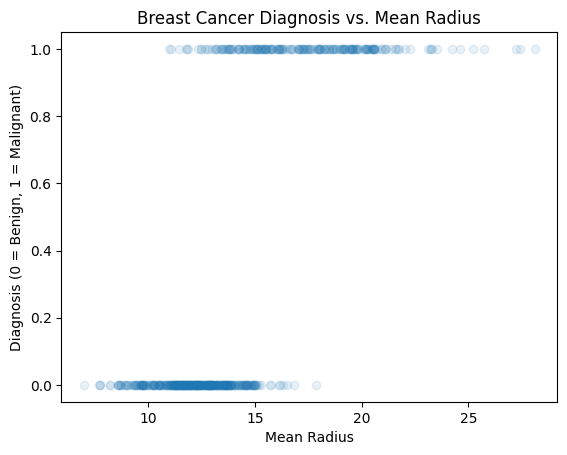

In [3]:
plt.scatter(breast_cancer_df['radius_mean'], breast_cancer_df['diagnosis_dummy'], alpha=0.1)
plt.xlabel('Mean Radius') 
plt.ylabel('Diagnosis (0 = Benign, 1 = Malignant)')  
plt.title('Breast Cancer Diagnosis vs. Mean Radius')

## Train-test split

In [4]:
breast_cancer_df_train, breast_cancer_df_test = train_test_split(breast_cancer_df, test_size=0.2, random_state=0)

## Implement using iterative WLS

In [5]:
def logistic_regression_iwls(data, y_col, x_cols, max_iter=10, tol=0.001):
    n = len(data)
    
    data = data.copy() 
    # data['intercept'] = 1
    # x_cols = ['intercept'] + x_cols
    
    X = data[x_cols].values
    y = data[y_col].values
    
    # Define the logit link function and its derivative
    def logit(p):
        return np.log(p / (1 - p))
    
    def logit_inv(eta):
        return 1 / (1 + np.exp(-eta))

    def logit_derivative(mu):
        # print(mu)
        return 1/(mu * (1 - mu))
    
    def b_double_derivative(theta):
        return n * (np.exp(theta)) / (1 + np.exp(theta))**2
    
    # Initial estimates for mu and eta using y, but perturb it else we run into numerical issues
    mu = np.where(y == 1, 0.99, 0.01)

    eta = logit(mu)
    theta = np.log(mu /(1-mu))
    
    # Initialize beta estimates
    beta = np.zeros(X.shape[1])

    beta_prev = beta
    for _ in range(max_iter):
        # Update z and weights w
        z = eta + (y - mu) * logit_derivative(mu)
        # w = 1/ (logit_derivative(mu) ** 2 * (mu * (1 - mu)))
        w = 1 / (logit_derivative(mu) ** 2 * b_double_derivative(theta))

        W = np.diag(w)
        
        XTWX_inv = np.linalg.inv(X.T @ W @ X)
        XTWZ = X.T @ W @ z
        beta = XTWX_inv @ XTWZ
        has_nan = np.any(np.isnan(beta))
        # if has_nan:
        #     print(beta_prev)
        #     return beta_prev

        # if np.max(np.abs(beta - beta_prev)) < tol:
        #     break
        eta = X @ beta
        mu = logit_inv(eta)
        beta_prev = beta
    print(beta)
    return beta

def predict(data, params, x_cols):
    data = data.copy()  # Make a copy to avoid modifying the original DataFrame
    X = data[x_cols].values
    linear_prediction = np.dot(X, params)
    pred_prob = 1 / (1 + np.exp(-linear_prediction))
    return pred_prob


x_cols = ['radius_mean']
# all_features = list(df.columns[2:-2])
# x_cols = all_features[:1]
x_cols = ['intercept'] + x_cols
params = logistic_regression_iwls(breast_cancer_df_train, 'diagnosis_dummy', x_cols, tol=0.1, max_iter=10000)

# Predict on test set
breast_cancer_df_test['pred_prob_glm'] = predict(breast_cancer_df_test, params, x_cols)

# Calculate accuracy
breast_cancer_df_test['predicted_diagnosis'] = (breast_cancer_df_test['pred_prob_glm'] > 0.5).astype(int)
accuracy_with_log_glm = (breast_cancer_df_test['predicted_diagnosis'] == breast_cancer_df_test['diagnosis_dummy']).mean()
print(f"Accuracy: {accuracy_with_log_glm}")

[-14.7545481    0.99404751]
Accuracy: 0.8947368421052632


## Implement using sm.GLM() (check that IWLS is correct)

In [6]:
import statsmodels.api as sm

model = sm.GLM(breast_cancer_df_train['diagnosis_dummy'], breast_cancer_df_train[x_cols], family=sm.families.Binomial())

# Fit the model
result = model.fit()

# Print the fitted parameters
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        diagnosis_dummy   No. Observations:                  455
Model:                            GLM   Df Residuals:                      453
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.40
Date:                Fri, 12 Apr 2024   Deviance:                       268.80
Time:                        10:09:28   Pearson chi2:                     394.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5128
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     -14.7120      1.420    -10.364      

## Illustration of Results

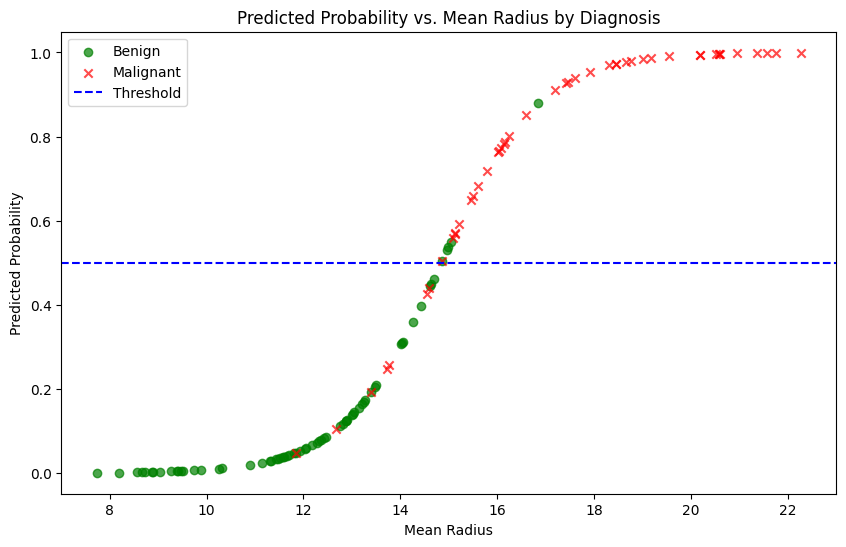

Accuracy using Logistic GLM: 0.8947368421052632


In [7]:
import matplotlib.pyplot as plt

benign = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 0]
malignant = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 1]

plt.figure(figsize=(10, 6))

plt.scatter(benign['radius_mean'], benign['pred_prob_glm'], color='green', marker='o', alpha=0.7, label='Benign')

plt.scatter(malignant['radius_mean'], malignant['pred_prob_glm'], color='red', marker='x', alpha=0.7, label='Malignant')

plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold')

plt.title('Predicted Probability vs. Mean Radius by Diagnosis')
plt.xlabel('Mean Radius')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

print(f"Accuracy using Logistic GLM: {accuracy_with_log_glm}")

## Using OLS to predict breast cancer

In [8]:
import statsmodels.formula.api as smf

model = smf.ols(formula='diagnosis_dummy ~ radius_mean', data=breast_cancer_df_train).fit()

print(model.summary())

breast_cancer_df_test['pred_prob_ols'] = model.predict(breast_cancer_df_test[['radius_mean']])

# Threshold the predicted values to get binary outcomes
breast_cancer_df_test['predicted_diagnosis_ols'] = (breast_cancer_df_test['pred_prob_ols'] > 0.5).astype(int)

accuracy_with_ols = (breast_cancer_df_test['predicted_diagnosis_ols'] == breast_cancer_df_test['diagnosis_dummy']).mean()

print(f"Model accuracy on test set: {accuracy_with_ols}")


                            OLS Regression Results                            
Dep. Variable:        diagnosis_dummy   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     500.0
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           3.62e-75
Time:                        10:09:28   Log-Likelihood:                -143.19
No. Observations:                 455   AIC:                             290.4
Df Residuals:                     453   BIC:                             298.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0289      0.064    -16.038      

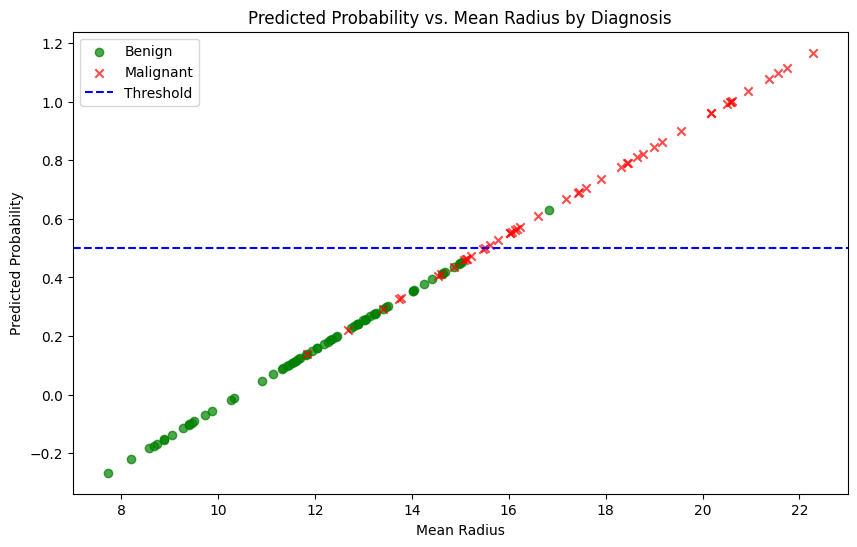

Accuracy using Logistic GLM: 0.8947368421052632


In [9]:
import matplotlib.pyplot as plt

benign = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 0]
malignant = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 1]

plt.figure(figsize=(10, 6))

plt.scatter(benign['radius_mean'], benign['pred_prob_ols'], color='green', marker='o', alpha=0.7, label='Benign')

plt.scatter(malignant['radius_mean'], malignant['pred_prob_ols'], color='red', marker='x', alpha=0.7, label='Malignant')

plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold')

plt.title('Predicted Probability vs. Mean Radius by Diagnosis')
plt.xlabel('Mean Radius')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

print(f"Accuracy using Logistic GLM: {accuracy_with_log_glm}")

# Modelling Poisson Distribution with GLM (Simulated Data)

In [10]:
np.random.seed(0)

n_samples = 10000
n_features = 2

X = np.random.uniform(-1, 1, (n_samples, n_features))

beta = np.linspace(2, 4, n_features)

lambda_ = np.exp(np.dot(X, beta))
y = np.random.poisson(lambda_)

features = {f'feat{i+1}': X[:, i] for i in range(n_features)}
poisson_df = pd.DataFrame({'target': y, **features})

poisson_df.head()

,target,feat1,feat2
0,9,0.097627,0.430379
1,3,0.205527,0.089766
2,0,-0.152690,0.291788
3,18,-0.124826,0.783546
4,3,0.927326,-0.233117


In [11]:
print(f"Ground truth beta: {beta}")

Ground truth beta: [2. 4.]


## Train test split

In [12]:
poisson_df_train, poisson_df_test = train_test_split(poisson_df, test_size=0.2, random_state=0)

## Implement using IWLS

In [13]:
import numpy as np

def poisson_glm(data, y_col, x_cols, max_iter=10, tol=0.001):
    n = len(data)
    
    data = data.copy()
    X = data[x_cols].values
    y = data[y_col].values
    
    def log_deriv(mu):
        return 1/mu
    
    mu = y + 0.01  # Adding 0.1 to avoid log(0) for initial estimation
    eta = np.log(mu)
    
    # Initialize beta estimates
    beta = np.zeros(X.shape[1])
    theta = np.log(mu)
    prev_beta = beta
    for _ in range(max_iter):
        print(beta)
        z = eta + (y - mu) * log_deriv(mu)
        w = 1 / (log_deriv(mu) ** 2 * np.exp(theta))
        
        W = np.diag(w)
        
        XTWX_inv = np.linalg.inv(X.T @ W @ X)
        XTWZ = X.T @ W @ z
        beta = XTWX_inv @ XTWZ

        eta = X @ beta
        mu = np.exp(eta)
        
        if np.max(np.abs(beta - prev_beta)) < tol:
            break
        prev_beta = beta
    
    return beta

def predict(data, params, x_cols):
    data = data.copy()  # Make a copy to avoid modifying the original DataFrame
    X = data[x_cols].values
    linear_prediction = np.dot(X, params)
    pred_count = np.exp(linear_prediction)  # Use exp since it's the inverse of the log link
    return pred_count

y_col = (poisson_df_train.columns[0])
x_cols = list(poisson_df_train.columns[1:])
x_cols = [f'feat{i}' for i in range(1, 1 + n_features)]
print(x_cols)
params = poisson_glm(poisson_df_train, y_col, x_cols, max_iter=1000, tol=0.01)
print(params)
poisson_df_train['predicted_counts'] = predict(poisson_df_train, params, x_cols)

['feat1', 'feat2']
[0. 0.]
[1.99687715 4.01227744]
[2.00569569 3.86579193]
[1.95450732 3.88923769]
[1.98856814 3.86161036]
[1.9620509  3.88202066]
[1.98240256 3.86618563]
[1.96674546 3.87829504]


[1.97878208 3.86894388]
[1.96952189 3.87611358]


## Implement using sm.GLM()

In [14]:
# y_col = (poisson_df_train.columns[0])
# x_cols = list(poisson_df_train.columns[1:])
# x_cols=['feat1']
model = sm.GLM(poisson_df_train[y_col], poisson_df_train[x_cols], family=sm.families.Poisson())

# Fit the model
result = model.fit()

# Print the fitted parameters
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11705.
Date:                Fri, 12 Apr 2024   Deviance:                       6520.6
Time:                        10:09:30   Pearson chi2:                 8.10e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feat1          2.0026      0.007    283.346      0.0

In [15]:
X_test, y_test = poisson_df_test[x_cols], poisson_df_test[y_col]
predictions = result.predict(X_test)
mae = np.mean(np.abs((y_test - predictions) )) * 100
print(f"MAE with Poisson GLM: {mae}")

MAE with Poisson GLM: 169.82168679924962


## Scatter plot

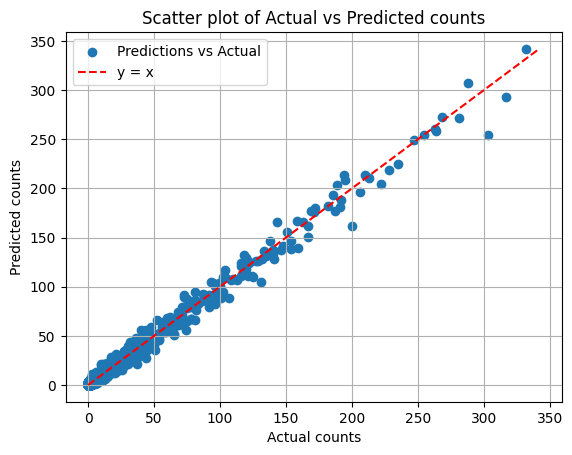

In [16]:
import matplotlib.pyplot as plt
plt.scatter(poisson_df_test['target'], predictions, label='Predictions vs Actual')

max_val = max(poisson_df_test['target'].max(), predictions.max())
min_val = min(poisson_df_test['target'].min(), predictions.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x') 

plt.xlabel('Actual counts')
plt.ylabel('Predicted counts')
plt.title('Scatter plot of Actual vs Predicted counts')
plt.legend()
plt.grid(True)
plt.show()

## Implement using OLS

In [17]:
formula_with_intercept = 'target ~ feat1 + feat2'
ols_model_with_intercept = smf.ols(formula=formula_with_intercept, data=poisson_df_train)
ols_result_with_intercept = ols_model_with_intercept.fit()
ols_predictions_with_intercept = ols_result_with_intercept.predict(poisson_df_test)
ols_mae_with_intercept = np.mean(np.abs((y_test - ols_predictions_with_intercept))) * 100

print(ols_result_with_intercept.summary())
print(f"MAE with OLS: {ols_mae_with_intercept}")

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     2146.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:09:30   Log-Likelihood:                -37557.
No. Observations:                8000   AIC:                         7.512e+04
Df Residuals:                    7997   BIC:                         7.514e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4702      0.296     42.130      0.0

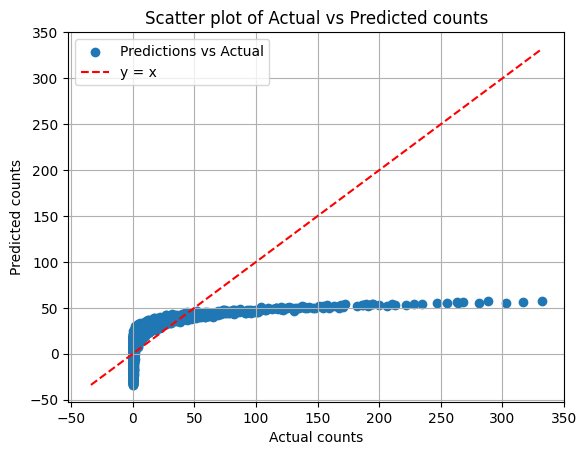

In [18]:
import matplotlib.pyplot as plt

plt.scatter(poisson_df_test['target'], ols_predictions_with_intercept, label='Predictions vs Actual')

max_val = max(poisson_df_test['target'].max(), ols_predictions_with_intercept.max())
min_val = min(poisson_df_test['target'].min(), ols_predictions_with_intercept.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')  

plt.xlabel('Actual counts')
plt.ylabel('Predicted counts')
plt.title('Scatter plot of Actual vs Predicted counts')
plt.legend()
plt.grid(True)
plt.show()
